In [1]:
using Rocket
using ReactiveMP
using GraphPPL
using Distributions
using LinearAlgebra

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.
┌ Info: Precompiling GraphPPL [b3f8163a-e979-4e85-b43e-1f63d8c8b42c]
└ @ Base loading.jl:1278
┌ Warning: Package GraphPPL does not have ReactiveMP in its dependencies:
│ - If you have GraphPPL checked out for development and have
│   added ReactiveMP as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with GraphPPL
└ Loading ReactiveMP into GraphPPL from project dependency, future 

In [2]:
@model function rotate_ssm(n, A, Q, P)
     
    x = randomvar(n)
    y = datavar(Vector{Float64}, n)
    
    x0_mean = datavar(Vector{Float64})
    x0_cov  = datavar(Matrix{Float64})
    
    x_prior ~ MvNormalMeanCovariance(x0_mean, x0_cov)
    
    x_prev = x_prior
    
    for i in 1:n
        x[i] ~ MvNormalMeanCovariance(A * x_prev, Q)
        y[i] ~ MvNormalMeanCovariance(x[i], P)
        
        x_prev = x[i]
    end
    
    return x, y, x0_mean, x0_cov
end

rotate_ssm (generic function with 1 method)

In [3]:
using Random

In [4]:
Random.seed!(123)

θ = π / 20
A = [ cos(θ) -sin(θ); sin(θ) cos(θ) ]
Q = Matrix(Diagonal(1.0 * ones(2)))
P = Matrix(Diagonal(1.0 * ones(2)))

n = 300

x_prev = [ 2.0, -2.0 ]

real_x = Vector{Vector{Float64}}(undef, n)
real_y = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    real_x[i] = rand(MvNormal(A * x_prev, Q))
    real_y[i] = rand(MvNormal(real_x[i], Q))
    
    x_prev = real_x[i]
end

In [5]:
using Plots

In [6]:
slicedim(dim) = (a) -> map(e -> e[dim], a)

slicedim (generic function with 1 method)

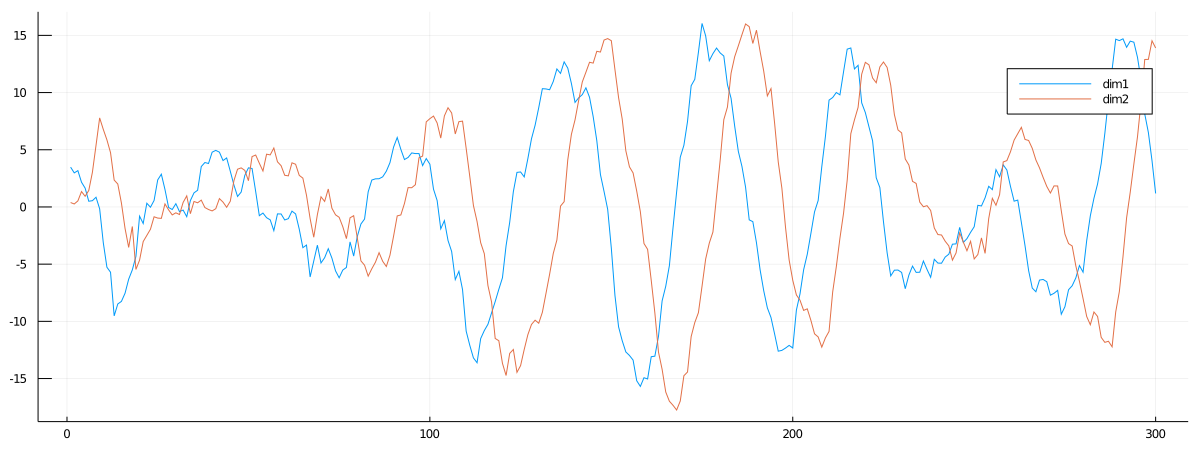

In [7]:
px = plot()

px = plot!(px, real_x |> slicedim(1), fillalpha = 0.2, label = :dim1)
px = plot!(px, real_x |> slicedim(2), fillalpha = 0.2, label = :dim2)

plot(px, size = (1200, 450))

In [8]:
model, (x, y, x0_mean, x0_cov) = rotate_ssm(n, A, Q, P);

x0_prior = MvNormalMeanCovariance([ 2.0, -2.0 ], Matrix(Diagonal(100.0 * ones(2))));

xmarginals = Vector{Marginal}(undef, n)

xsub = subscribe!(collectLatest(Marginal, map(getmarginal, x), Vector{Marginal}, identity), (xs) -> copyto!(xmarginals, xs))

update!(x0_mean, mean(x0_prior))
update!(x0_cov, cov(x0_prior))
update!(y, real_y)

unsubscribe!(xsub)

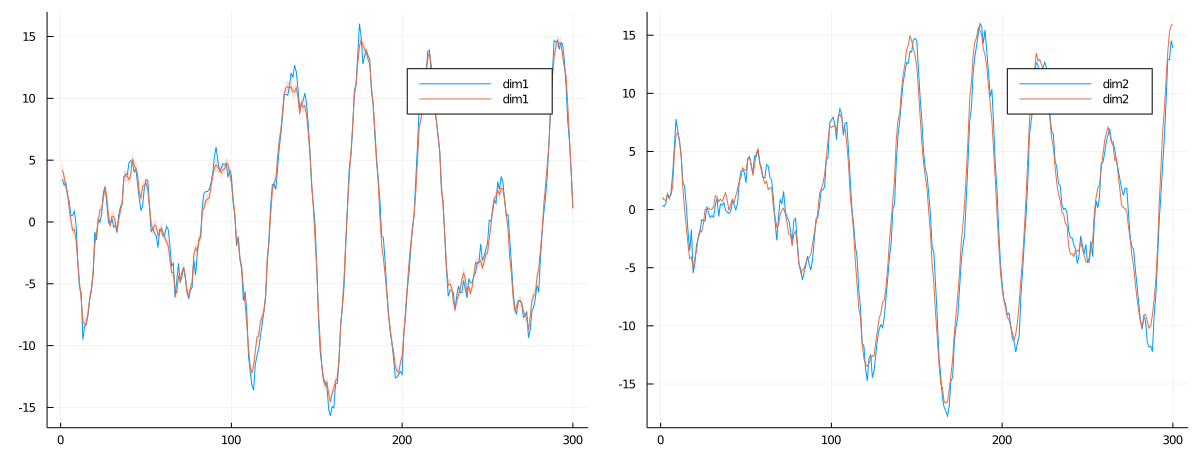

In [10]:
px1 = plot()
px2 = plot()

px1 = plot!(px1, real_x |> slicedim(1), fillalpha = 0.2, label = :dim1)
px2 = plot!(px2, real_x |> slicedim(2), fillalpha = 0.2, label = :dim2)
px1 = plot!(px1, mean.(xmarginals) |> slicedim(1), ribbon = cov.(xmarginals) |> slicedim(1), fillalpha = 0.2, label = :dim1)
px2 = plot!(px2, mean.(xmarginals) |> slicedim(2), ribbon = cov.(xmarginals) |> slicedim(2), fillalpha = 0.2, label = :dim2)

plot(px1, px2, size = (1200, 450))